# Transformation Pipeline

We have 3 input datasets: 
```
customers.csv
non-customers.csv
activity.csv
```

* The `customers.csv` file contains information about the customers who are converted to Premium account
* The `non-customers.csv` file contains information about the customers who are NOT converted to Premium account
* The `activity.csv` file contains all customers activity.

I defined the following data transformers (see the below figure). 

**CustomerDataTransformer**
* It will take data from `customers` file and generates `premium_customers_df`. 
* It will take data from `non-customers` file and generates `fremium_customers_df`. 

**ActivityDataTransformer**
* It will take the `activity` file, and auguments with the missing customer activity. 
* It has been assumed that the marketing campaign runs every Monday.
* Whenever there is NO customer activity in a given week, we will augument that with 0 values, along with the `LASTUSED` column. This will represent when the user has last interacted with the system (in days). Given that we have weekly user activity, this is always going to be a multiple of 7
* This will produce `activity_df_transformed` (data frame)

**PaidActivityTransformer**
* This will join the `premium_customers_df` and `activity_df_transformed` dataframes.
* It will add a new column named `MEMBERSHIP`. This column can contain one either `BEFORE-PREMIUM` or `PREMIUM`.
* If the customer's membership date is greater than the activity date, then we assign `BEFORE-PREMIUM` to the `MEMBERSHIP` else, it will be `PREMIUM`
* Produces `premium_activity_df`

**NonPaidActivityTransformer**
* This will join the `fremium_customers_df` and `activity_df_transformed` dataframes.
* It will add a new column named `MEMBERSHIP`. This column will contain `FREE`
* Produces `fremium_activity_df`

### NOTE: The code is saved in `./util.py`. For convenience, the same code is also given in the _Pipeline Code_ Section of this document

The below figure shows the data flow to generate the final `all_activity_df`. 


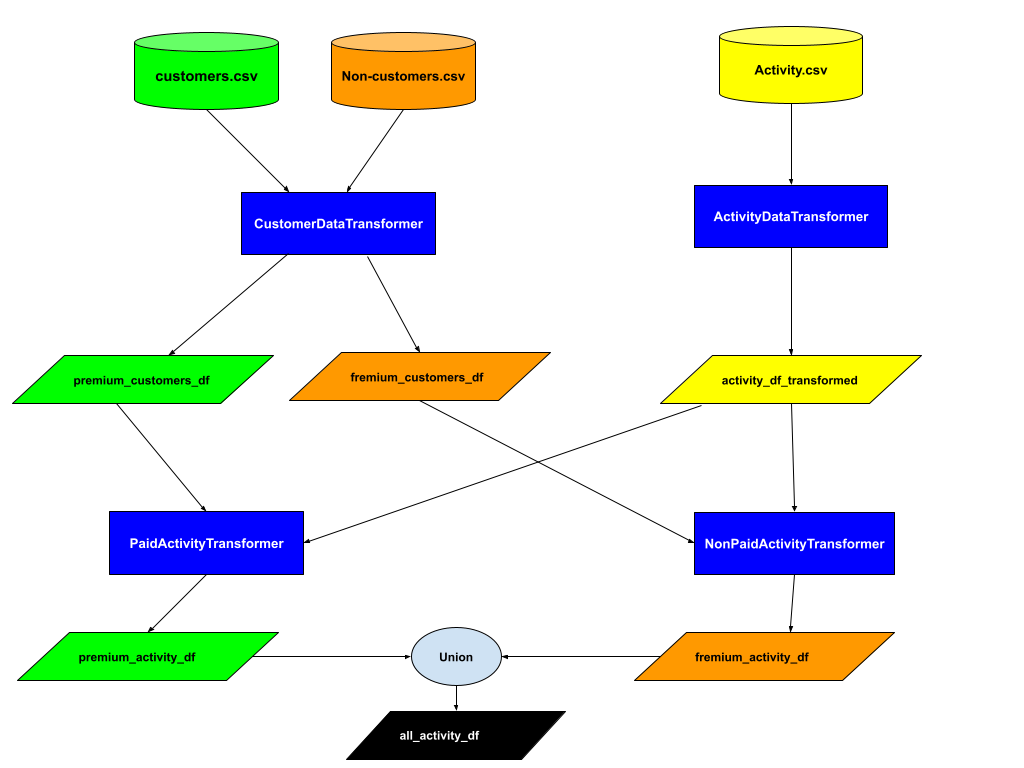
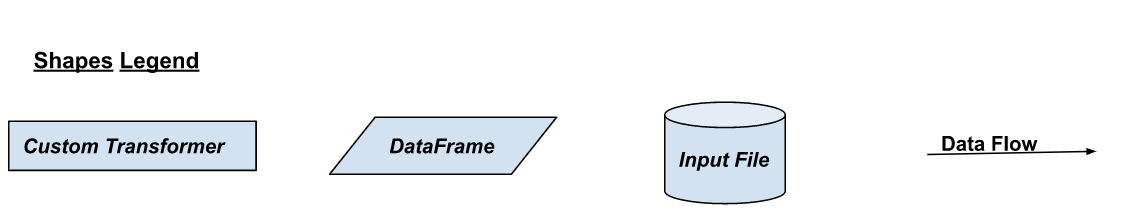

# Pipeline Code

In [2]:
# Pipeline Code
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CustomerDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ds_type, drop_columns):
        self.drop_columns = drop_columns
        self.ds_type = ds_type
        
    def fit(self, X, y=None):
        return self
    
    def process_drop_columns(self, X):
        for i in self.drop_columns:
            X.drop(i, axis=1, inplace=True)

    def transform(self, X):
        self.process_drop_columns(X)
        if self.ds_type.lower() == 'fremium':
            X['CLOSEDATE'] = None
            X['MRR'] = 0
        return X[['id','CLOSEDATE', 'ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'MRR']]            
    

class ActivityDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def process_dates(self, X):
        ACTIVITYDATE,_ = zip(*X['WHEN_TIMESTAMP'].str.split())
        X['ACTIVITYDATE'] = ACTIVITYDATE    

    def create_marketing_data(self, id, from_date, to_date):
        # Assumed that the weekly marketing campaign happens on Monday
        dates = pd.date_range(from_date,to_date, freq='W-MON', inclusive='both').tolist()
        dates = [str(d.date()) for d in dates]
        marketing_campaign = pd.DataFrame(dates, columns=['DATE'])
        marketing_campaign['id'] = id
        return marketing_campaign    
    
    def generate_marketing_data(self, X):
        activity_ids = list(set(X["id"]))
        marketing_df = pd.DataFrame()
        
        for id in activity_ids:
            from_date = X[X["id"] == id]["ACTIVITYDATE"].min()
            to_date = X["ACTIVITYDATE"].max()    
            # to_date will always evaluate to 2020-07-27 (last marketing day)
            # to_date = '2020-07-27'
            marketing_df = pd.concat([marketing_df, 
                                           self.create_marketing_data(id, from_date, to_date)], 
                                     ignore_index = True)
        return marketing_df
    
    
    def augument_data(self, X, marketing_df):
        '''
        The goal is to add the LASTUSED info
        '''
        augmented_activity_df = marketing_df.merge(X,
                                                   left_on=['id', 'DATE'], 
                                                   right_on=['id', 'ACTIVITYDATE'], 
                                                   how='left')        
        
        augmented_activity_df = augmented_activity_df.sort_values(by=["id", "DATE"])
        
        augmented_activity_df['ADJUSTEDDATE'] = augmented_activity_df['ACTIVITYDATE'].fillna(method='ffill')
        
        # augmented_activity_df.drop(['ACTIVITYDATE'], inplace=True, axis=1)
        
        augmented_activity_df['LASTUSED'] = (pd.to_datetime(augmented_activity_df.DATE, 
                                                            format="%Y-%m-%d") - 
                                             pd.to_datetime(augmented_activity_df.ADJUSTEDDATE,
                                                            format="%Y-%m-%d")
                                            ).dt.days
        
        augmented_activity_df.fillna(0, inplace=True)
        
        return augmented_activity_df
    
    def transform(self, X):
        self.process_dates(X)
        marketing_df = self.generate_marketing_data(X)
        augumented_df = self.augument_data(X, marketing_df)
        augumented_df.drop('WHEN_TIMESTAMP', axis=1, inplace=True)
        return augumented_df
    

class PaidActivityJoiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
        
    def transform(self, X, premium_customers_df):
        customer_augmented_activity_df = premium_customers_df.merge(X,
                                                                    left_on='id', 
                                                                    right_on='id', 
                                                                    how='inner')
        customer_augmented_activity_df['MEMBERSHIPTYPE'] = None
        customer_augmented_activity_df.loc[(pd.to_datetime(
                                                            customer_augmented_activity_df.CLOSEDATE, 
                                                            format="%Y-%m-%d") > 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'BEFORE-PREMIUM'

        customer_augmented_activity_df.loc[(pd.to_datetime(customer_augmented_activity_df.CLOSEDATE, 
                                                           format="%Y-%m-%d") <= 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'PREMIUM' 
        
        
        customer_augmented_activity_df.drop(['CLOSEDATE', 'ADJUSTEDDATE', 'ACTIVITYDATE'], axis=1, inplace=True)
        return customer_augmented_activity_df


class NonPaidActivityJoiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
        
    def transform(self, X, fremium_customers_df):
        customer_augmented_activity_df = fremium_customers_df.merge(X,
                                                                    left_on='id', 
                                                                    right_on='id', 
                                                                    how='inner')
        customer_augmented_activity_df['MEMBERSHIPTYPE'] = 'FREE'
        customer_augmented_activity_df.loc[(pd.to_datetime(
                                                            customer_augmented_activity_df.CLOSEDATE, 
                                                            format="%Y-%m-%d") > 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'BEFORE-PREMIUM'

        customer_augmented_activity_df.loc[(pd.to_datetime(customer_augmented_activity_df.CLOSEDATE, 
                                                           format="%Y-%m-%d") <= 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'PREMIUM' 
        
        
        customer_augmented_activity_df.drop(['CLOSEDATE', 'ADJUSTEDDATE', 'ACTIVITYDATE'], axis=1, inplace=True)
        return customer_augmented_activity_df
    

def transform_data(customers_file_path, non_customers_file_path, activity_file_path):
    # Create premium_customers_df
    premium_customers_df = pd.read_csv(customers_file_path,infer_datetime_format=True)

    premium_customer_transformer = CustomerDataTransformer(ds_type='premium', drop_columns=[]
                                                       #drop_columns=['ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'MRR']
                                                      )
    premium_customers_df = premium_customer_transformer.transform(premium_customers_df)


    # Create fremium_customers_df
    fremium_customers_df = pd.read_csv(non_customers_file_path,infer_datetime_format=True)
    fremium_customer_transformer = CustomerDataTransformer(ds_type='fremium', drop_columns = []
                                                       #drop_columns=['ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY']
                                                      )
    fremium_customers_df = fremium_customer_transformer.transform(fremium_customers_df)



    # Create activity_df_transformed    
    activity_df = pd.read_csv(activity_file_path,infer_datetime_format=True)
    activity_transformer = ActivityDataTransformer()
    activity_df_transformed = activity_transformer.transform(activity_df)    

    # Paid members activity
    paid_activity_transformer = PaidActivityJoiner()
    paid_activity_df = paid_activity_transformer.transform(activity_df_transformed, premium_customers_df)

    # Unpaid members activity
    non_paid_activity_transformer = NonPaidActivityJoiner()
    non_paid_activity_df = non_paid_activity_transformer.transform(activity_df_transformed, fremium_customers_df)

    # Final data frame
    all_activity_df = pd.concat([paid_activity_df, non_paid_activity_df])
    
    return all_activity_df


In [3]:
all_activity_df = transform_data("./customers (4).csv", "./noncustomers (4).csv", "./usage_actions (4).csv")

In [4]:
all_activity_df.head()

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM


In [8]:
all_activity_df.shape

(144448, 16)

# Code Development Work (Ignore)

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

In [7]:
class CustomerDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, ds_type, drop_columns):
        self.drop_columns = drop_columns
        self.ds_type = ds_type
        
    def fit(self, X, y=None):
        return self
    
    def process_drop_columns(self, X):
        for i in self.drop_columns:
            X.drop(i, axis=1, inplace=True)

    def transform(self, X):
        self.process_drop_columns(X)
        if self.ds_type.lower() == 'fremium':
            X['CLOSEDATE'] = None
            X['MRR'] = 0
        return X[['id','CLOSEDATE', 'ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'MRR']]            

In [8]:
premium_customers_df = pd.read_csv("./customers (4).csv",infer_datetime_format=True)
premium_customer_transformer = CustomerDataTransformer(ds_type='premium', drop_columns=[]
                                                       #drop_columns=['ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY', 'MRR']
                                                      )
premium_customers_df = premium_customer_transformer.transform(premium_customers_df)
premium_customers_df.head()

,id,CLOSEDATE,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR
0,199,2019-06-20,309343,201 to 1000,Other,290.00
1,147,2019-03-22,16000001,51 to 200,NaN,392.54
2,118,2020-01-08,60502,1001 to 10000,HIGHER_EDUCATION,-61.15
3,126,2019-09-19,3575321,201 to 1000,CONSUMER_SERVICES,400.00
4,174,2019-01-27,273063,26 to 50,Technology - Software,209.98


In [10]:
fremium_customers_df = pd.read_csv("./noncustomers (4).csv",infer_datetime_format=True)
fremium_customer_transformer = CustomerDataTransformer(ds_type='fremium', drop_columns = []
                                                       #drop_columns=['ALEXA_RANK', 'EMPLOYEE_RANGE', 'INDUSTRY']
                                                      )
fremium_customers_df = fremium_customer_transformer.transform(fremium_customers_df)
fremium_customers_df.head()

,id,CLOSEDATE,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR
0,4916,None,4489573.0,11 to 25,NaN,0
1,3489,None,4027013.0,6 to 10,NaN,0
2,2813,None,16000001.0,26 to 50,COMPUTER_SOFTWARE,0
3,727,None,814822.0,1001 to 10000,HOSPITAL_HEALTH_CARE,0
4,2166,None,16000001.0,26 to 50,NaN,0


In [11]:
class ActivityDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def process_dates(self, X):
        ACTIVITYDATE,_ = zip(*X['WHEN_TIMESTAMP'].str.split())
        X['ACTIVITYDATE'] = ACTIVITYDATE    

    def create_marketing_data(self, id, from_date, to_date):
        # Assumed that the weekly marketing campaign happens on Monday
        dates = pd.date_range(from_date,to_date, freq='W-MON', inclusive='both').tolist()
        dates = [str(d.date()) for d in dates]
        marketing_campaign = pd.DataFrame(dates, columns=['DATE'])
        marketing_campaign['id'] = id
        return marketing_campaign    
    
    def generate_marketing_data(self, X):
        activity_ids = list(set(X["id"]))
        marketing_df = pd.DataFrame()
        
        for id in activity_ids:
            from_date = X[X["id"] == id]["ACTIVITYDATE"].min()
            to_date = X["ACTIVITYDATE"].max()    
            # to_date will always evaluate to 2020-07-27 (last marketing day)
            # to_date = '2020-07-27'
            marketing_df = pd.concat([marketing_df, 
                                           self.create_marketing_data(id, from_date, to_date)], 
                                     ignore_index = True)
        return marketing_df
    
    
    def augument_data(self, X, marketing_df):
        '''
        The goal is to add the LASTUSED info
        '''
        augmented_activity_df = marketing_df.merge(X,
                                                   left_on=['id', 'DATE'], 
                                                   right_on=['id', 'ACTIVITYDATE'], 
                                                   how='left')        
        
        augmented_activity_df = augmented_activity_df.sort_values(by=["id", "DATE"])
        
        augmented_activity_df['ADJUSTEDDATE'] = augmented_activity_df['ACTIVITYDATE'].fillna(method='ffill')
        
        # augmented_activity_df.drop(['ACTIVITYDATE'], inplace=True, axis=1)
        
        augmented_activity_df['LASTUSED'] = (pd.to_datetime(augmented_activity_df.DATE, 
                                                            format="%Y-%m-%d") - 
                                             pd.to_datetime(augmented_activity_df.ADJUSTEDDATE,
                                                            format="%Y-%m-%d")
                                            ).dt.days
        
        augmented_activity_df.fillna(0, inplace=True)
        
        return augmented_activity_df
    
    def transform(self, X):
        self.process_dates(X)
        marketing_df = self.generate_marketing_data(X)
        augumented_df = self.augument_data(X, marketing_df)
        augumented_df.drop('WHEN_TIMESTAMP', axis=1, inplace=True)
        return augumented_df

In [12]:
activity_df = pd.read_csv("./usage_actions (4).csv",infer_datetime_format=True)
activity_transformer = ActivityDataTransformer()
activity_df_transformed = activity_transformer.transform(activity_df)

In [13]:
activity_df_transformed.head(10)

,DATE,id,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,ACTIVITYDATE,ADJUSTEDDATE,LASTUSED
0,2019-01-07,1,46.0,1.0,2.0,6.0,3.0,1.0,1.0,1.0,2019-01-07,2019-01-07,0
1,2019-01-14,1,213.0,10.0,74.0,10.0,2.0,2.0,2.0,1.0,2019-01-14,2019-01-14,0
2,2019-01-21,1,138.0,4.0,45.0,5.0,2.0,2.0,2.0,1.0,2019-01-21,2019-01-21,0
3,2019-01-28,1,208.0,61.0,87.0,7.0,4.0,2.0,3.0,1.0,2019-01-28,2019-01-28,0
4,2019-02-04,1,296.0,102.0,24.0,0.0,4.0,4.0,2.0,0.0,2019-02-04,2019-02-04,0
5,2019-02-11,1,335.0,38.0,87.0,0.0,2.0,2.0,2.0,0.0,2019-02-11,2019-02-11,0
6,2019-02-18,1,238.0,16.0,54.0,0.0,2.0,2.0,2.0,0.0,2019-02-18,2019-02-18,0
7,2019-02-25,1,158.0,16.0,43.0,0.0,2.0,2.0,2.0,0.0,2019-02-25,2019-02-25,0
8,2019-03-04,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-02-25,7
9,2019-03-11,1,199.0,13.0,31.0,4.0,3.0,2.0,1.0,1.0,2019-03-11,2019-03-11,0


In [14]:
activity_df.shape

(25387, 11)

In [15]:
activity_df_transformed.shape

(144373, 13)

In [16]:
activity_df_transformed[activity_df_transformed["id"]==199]

,DATE,id,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,ACTIVITYDATE,ADJUSTEDDATE,LASTUSED
11017,2019-01-07,199,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,2019-01-07,2019-01-07,0
11018,2019-01-14,199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2019-01-07,7
11019,2019-01-21,199,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,2019-01-21,2019-01-21,0
11020,2019-01-28,199,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,2019-01-28,2019-01-28,0
11021,2019-02-04,199,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,2019-02-04,2019-02-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11094,2020-06-29,199,174.0,0.0,11.0,20.0,9.0,0.0,2.0,4.0,2020-06-29,2020-06-29,0
11095,2020-07-06,199,80.0,1.0,7.0,19.0,10.0,1.0,2.0,9.0,2020-07-06,2020-07-06,0
11096,2020-07-13,199,73.0,0.0,0.0,28.0,11.0,0.0,0.0,6.0,2020-07-13,2020-07-13,0
11097,2020-07-20,199,142.0,1.0,4.0,15.0,9.0,1.0,1.0,5.0,2020-07-20,2020-07-20,0


In [17]:
# Declare the premium_customers_df as a global variable
# Declare the fremium_customers_df as a global variable

class PaidActivityJoiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
        
    def transform(self, X):
        customer_augmented_activity_df = premium_customers_df.merge(X,
                                                                    left_on='id', 
                                                                    right_on='id', 
                                                                    how='inner')
        customer_augmented_activity_df['MEMBERSHIPTYPE'] = None
        customer_augmented_activity_df.loc[(pd.to_datetime(
                                                            customer_augmented_activity_df.CLOSEDATE, 
                                                            format="%Y-%m-%d") > 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'BEFORE-PREMIUM'

        customer_augmented_activity_df.loc[(pd.to_datetime(customer_augmented_activity_df.CLOSEDATE, 
                                                           format="%Y-%m-%d") <= 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'PREMIUM' 
        
        
        customer_augmented_activity_df.drop(['CLOSEDATE', 'ADJUSTEDDATE', 'ACTIVITYDATE'], axis=1, inplace=True)
        return customer_augmented_activity_df


In [18]:
paid_activity_transformer = PaidActivityJoiner()
paid_activity_df = paid_activity_transformer.transform(activity_df_transformed)
paid_activity_df.sort_values(by=["id", "DATE"]).head(10)

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
3352,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-07,46.0,1.0,2.0,6.0,3.0,1.0,1.0,1.0,0,BEFORE-PREMIUM
3353,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-14,213.0,10.0,74.0,10.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM
3354,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-21,138.0,4.0,45.0,5.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM
3355,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-28,208.0,61.0,87.0,7.0,4.0,2.0,3.0,1.0,0,BEFORE-PREMIUM
3356,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-04,296.0,102.0,24.0,0.0,4.0,4.0,2.0,0.0,0,PREMIUM
3357,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-11,335.0,38.0,87.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3358,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-18,238.0,16.0,54.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3359,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-25,158.0,16.0,43.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3360,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM
3361,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-11,199.0,13.0,31.0,4.0,3.0,2.0,1.0,1.0,0,PREMIUM


In [19]:
paid_activity_df[paid_activity_df["id"] == 199]

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
0,199,309343,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM
1,199,309343,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
2,199,309343,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM
3,199,309343,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM
4,199,309343,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,199,309343,201 to 1000,Other,290.0,2020-06-29,174.0,0.0,11.0,20.0,9.0,0.0,2.0,4.0,0,PREMIUM
78,199,309343,201 to 1000,Other,290.0,2020-07-06,80.0,1.0,7.0,19.0,10.0,1.0,2.0,9.0,0,PREMIUM
79,199,309343,201 to 1000,Other,290.0,2020-07-13,73.0,0.0,0.0,28.0,11.0,0.0,0.0,6.0,0,PREMIUM
80,199,309343,201 to 1000,Other,290.0,2020-07-20,142.0,1.0,4.0,15.0,9.0,1.0,1.0,5.0,0,PREMIUM


In [20]:
# Declare the premium_customers_df as a global variable
# Declare the fremium_customers_df as a global variable

class NonPaidActivityJoiner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
        
    def transform(self, X):
        customer_augmented_activity_df = fremium_customers_df.merge(X,
                                                                    left_on='id', 
                                                                    right_on='id', 
                                                                    how='inner')
        customer_augmented_activity_df['MEMBERSHIPTYPE'] = 'FREE'
        customer_augmented_activity_df.loc[(pd.to_datetime(
                                                            customer_augmented_activity_df.CLOSEDATE, 
                                                            format="%Y-%m-%d") > 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'BEFORE-PREMIUM'

        customer_augmented_activity_df.loc[(pd.to_datetime(customer_augmented_activity_df.CLOSEDATE, 
                                                           format="%Y-%m-%d") <= 
                                            pd.to_datetime(customer_augmented_activity_df.ADJUSTEDDATE, 
                                                           format="%Y-%m-%d")), 'MEMBERSHIPTYPE'] = 'PREMIUM' 
        
        
        customer_augmented_activity_df.drop(['CLOSEDATE', 'ADJUSTEDDATE', 'ACTIVITYDATE'], axis=1, inplace=True)
        return customer_augmented_activity_df


In [21]:
non_paid_activity_transformer = NonPaidActivityJoiner()
non_paid_activity_df = non_paid_activity_transformer.transform(activity_df_transformed)
non_paid_activity_df.sort_values(by=["id", "DATE"]).head(10)

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
131987,202,16000001.0,NaN,NaN,0,2020-06-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
131988,202,16000001.0,NaN,NaN,0,2020-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,FREE
131989,202,16000001.0,NaN,NaN,0,2020-06-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,FREE
131990,202,16000001.0,NaN,NaN,0,2020-06-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,FREE
131991,202,16000001.0,NaN,NaN,0,2020-07-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,FREE
131992,202,16000001.0,NaN,NaN,0,2020-07-13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35,FREE
131993,202,16000001.0,NaN,NaN,0,2020-07-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42,FREE
131994,202,16000001.0,NaN,NaN,0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49,FREE
1953,203,3093631.0,6 to 10,COMPUTER_SOFTWARE,0,2019-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
1954,203,3093631.0,6 to 10,COMPUTER_SOFTWARE,0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE


In [22]:
paid_activity_df.sort_values(by=["id", "DATE"]).head(10)

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
3352,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-07,46.0,1.0,2.0,6.0,3.0,1.0,1.0,1.0,0,BEFORE-PREMIUM
3353,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-14,213.0,10.0,74.0,10.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM
3354,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-21,138.0,4.0,45.0,5.0,2.0,2.0,2.0,1.0,0,BEFORE-PREMIUM
3355,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-01-28,208.0,61.0,87.0,7.0,4.0,2.0,3.0,1.0,0,BEFORE-PREMIUM
3356,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-04,296.0,102.0,24.0,0.0,4.0,4.0,2.0,0.0,0,PREMIUM
3357,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-11,335.0,38.0,87.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3358,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-18,238.0,16.0,54.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3359,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-02-25,158.0,16.0,43.0,0.0,2.0,2.0,2.0,0.0,0,PREMIUM
3360,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,PREMIUM
3361,1,2610402,2 to 5,RENEWABLES_ENVIRONMENT,40.0,2019-03-11,199.0,13.0,31.0,4.0,3.0,2.0,1.0,1.0,0,PREMIUM


In [23]:
df = pd.concat([paid_activity_df, non_paid_activity_df])
df

,id,ALEXA_RANK,EMPLOYEE_RANGE,INDUSTRY,MRR,DATE,ACTIONS_CRM_CONTACTS,ACTIONS_CRM_COMPANIES,ACTIONS_CRM_DEALS,ACTIONS_EMAIL,USERS_CRM_CONTACTS,USERS_CRM_COMPANIES,USERS_CRM_DEALS,USERS_EMAIL,LASTUSED,MEMBERSHIPTYPE
0,199,309343.0,201 to 1000,Other,290.0,2019-01-07,61.0,0.0,0.0,7.0,10.0,0.0,0.0,4.0,0,BEFORE-PREMIUM
1,199,309343.0,201 to 1000,Other,290.0,2019-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,BEFORE-PREMIUM
2,199,309343.0,201 to 1000,Other,290.0,2019-01-21,21.0,0.0,0.0,33.0,6.0,0.0,0.0,6.0,0,BEFORE-PREMIUM
3,199,309343.0,201 to 1000,Other,290.0,2019-01-28,108.0,0.0,3.0,74.0,9.0,0.0,1.0,10.0,0,BEFORE-PREMIUM
4,199,309343.0,201 to 1000,Other,290.0,2019-02-04,114.0,0.0,5.0,58.0,10.0,0.0,2.0,9.0,0,BEFORE-PREMIUM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133277,4672,16000001.0,2 to 5,NaN,0.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
133278,2479,16000001.0,26 to 50,NaN,0.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
133279,3639,4284768.0,6 to 10,NaN,0.0,2020-07-27,2.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,FREE
133280,4011,16000001.0,51 to 200,NaN,0.0,2020-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,FREE
